In [122]:
import json
import re
import math
import dateutil
import csv
from collections import defaultdict
from dateutil import parser as date_parser
from datetime import datetime

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

re_id = re.compile("[0-9]{13}")
def extract(func):
    for row in open("records.json"):
        js = json.loads(row)
        if func(js):
            yield js
            
            
def parse_date(s):
    dt = date_parser.parse(s)
    if dt.year > 2016:
        return datetime(year=dt.year - 100, month=dt.month, day=dt.day)
    return dt

def calc_age(idno):
    if not re_id.match(idno):
        return False
    try:
        yob = int("19" + idno[0:2])
        return 2016 - yob
    except ValueError:
        return "N/A"

def avg(vals):
    total = 0
    count = 0
    for v in vals:
        try:
            total += v
            count += 1
        except (ValueError, TypeError):
            continue
    if count <= 0:
        return None
    return total/float(count)

def conjoin(*args):
    def predicate(el):
        for pred in args:
            if not pred(el):
                return False
        return True
    return predicate

def invert(func):
    def predicate(el):
        if func(el):
            return False
        return True
    return predicate

def has_sa_id(js):
    if re_id.match(js["idno"]):
        return True
    return False

def is_male(js):
    if has_sa_id(js):
        idno = js["idno"]
        gdigits = int(idno[6:10])
        return gdigits > 5000
    return False

def is_female(js):
    if has_sa_id(js):
        idno = js["idno"]
        gdigits = int(idno[6:10])
        return gdigits < 5000
    return False

def extract_register(register):
    def predicate(js):
        for reg in js["registrations"]:
            if not reg["status"] == "ACTIVE":
                continue
            if reg["register"] == register:
                return True
        return False

    return predicate

def extract_speciality(speciality):
    def predicate(js):
        for reg in js["registrations"]:
            for cat in reg["categories"]:
                if cat["speciality"] == speciality:
                    return True
        return False
    return predicate

def extract_subspeciality(subspeciality):
    def predicate(js):
        for reg in js["registrations"]:
            for cat in reg["categories"]:
                if cat["sub_speciality"] == subspeciality:
                    return True
        return False
    return predicate

def median(vals):
    vals.sort()
    l = len(vals)
    if l % 2 == 0:
        return (vals[l / 2 - 1] + vals[1 / 2]) / 2.0
    return vals[int(math.floor(l / 2))]

def age_at_first_qualification(el):
    from dateutil import parser
    idno = el["idno"]
    try:
        dob_s = "19" + idno[0:2] + "-" + idno[2:4] + "-" + idno[4:6]
        dob = parser.parse(dob_s)
    except ValueError:
        print dob_s, idno
        return None
    
    yob = dob.year
    if yob > 2016:
        yob -= 100
        

    dates = []
    for reg in el["registrations"]:
        for q in reg["qualifications"]:
            if q["date"] == None:
                continue
            grad_date = parser.parse(q["date"])
            grad_year = grad_date.year
            if grad_year > 2016:
                grad_year -= 100
            dates.append([grad_year, q["degree"]]) 
    dates = sorted(dates, key=lambda x : x[0])
    if len(dates) > 0:
        age_at_grad = dates[0][0] - yob
        grad_year = dates[0]
        if (age_at_grad < 16):
            return None
        return (age_at_grad, grad_year[0], yob, dates[0][1])
    return None
                
    
extract_vascular = conjoin(has_sa_id, extract_subspeciality("VASCULAR SURGERY"))
extract_psychologist = conjoin(has_sa_id, extract_speciality("PSYCHIATRY"))
extract_medprac = conjoin(has_sa_id, extract_register("MEDICAL PRACTITIONERS"))

In [88]:


ages = []

count = 0
fp = open("grad.csv", "w")
w = csv.writer(fp)
w.writerow(["age,year,degree"])

for js in extract(extract_medprac):
    
    idno = js["idno"]
    age = age_at_first_qualification(js)
        
    if age == None:
        continue
        
    ages.append(age[0])
    w.writerow([age[0], age[1], age[3]])
    
fp.close()
print "Median age: ", median(ages)
print "Count: ", len(ages)

1966-00-40 6600408077908
1978-30-80 78308081852187
1969-07-00 69070060920188
1929-06-46 2906465123004
1956-00-10 56001085259086
1958-04-41 5804412507108
1980-00-12 80001265820183
1961-15-06 6115065959181
Median age:  24
Count:  39141


In [101]:
extract_foreign = conjoin(invert(has_sa_id), extract_register("MEDICAL PRACTITIONERS"))
count = defaultdict(int)
for js in extract(extract_foreign):
    for reg in js["registrations"]:
        for qual in reg["qualifications"]:
            degree = qual["degree"]
            count[degree] += 1
            continue

print sorted(count.items(), key=lambda x: x[1])


[(u'MB BS Karachi', 1), (u'FC Derm (SA)', 1), (u'FC Ophth (SA)', 1), (u'BM BCh Oxfd', 1), (u'DIH Pret', 1), (u'Dip Med Cluj', 1), (u'Cert Nephrology (SA)', 1), (u'FRCS Irel', 1), (u'MMed (Surg) Pret', 1), (u'MD Rwanda', 1), (u'MMed (O and G) Natal', 1), (u'Dip Med Athens', 1), (u'FF Rad (D) (SA)', 1), (u'MB BS Makerere', 1), (u'FCP (SA) Paed', 1), (u'M Phil (Maternal and Child Health) Cape Town', 1), (u'MMed (ORL) Orange Free State', 1), (u'Dip in Med Iasi', 1), (u'Dip in Med Med Acad Poznan', 1), (u'MB BS Khartoum', 1), (u'MMed (Psych) Orange Free State', 1), (u'MMed Fam Med Stell', 1), (u'DOH Cape Town', 1), (u'Cert Critical Care (SA)', 1), (u'M Fam Med Oranje-Vrystaat', 1), (u'MMed (Chir) Orange Free State', 1), (u'MD Istanbul', 1), (u'DTH Pret', 1), (u'Dip in Med Timisoara', 1), (u'Dip in Med Sarajevo', 1), (u'M Fam Med Natal', 1), (u'Dip in Med Med Inst Plovdiv', 1), (u'FRCP Glasg', 1), (u'FC Rad (SA) DIAG', 1), (u'Dip in Med Med Acad Voronech', 1), (u'MD Agostinho Neto', 1), (u'M

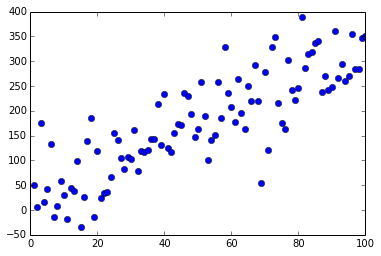

In [104]:
np.random.seed(5)
x = np.arange(1, 101)
y = 20 + 3 * x + np.random.normal(0, 60, 100)
plt.plot(x, y, "o")


In [150]:
def json_serial(obj):
    if isinstance(obj, datetime):
        serial = obj.isoformat()
        return serial
    raise TypeError ("Type not serializable")

female_vascular = conjoin(extract_vascular)
#female_vascular = conjoin(extract_speciality("CARDIOTHORACIC SURGERY"))
arr = []
for js in extract(female_vascular):
    degrees = []
    for reg in js["registrations"]:
        for q in reg["qualifications"]:
            degrees.append({"date" : parse_date(q["date"]), "degree" : q["degree"]})
    degrees = sorted(degrees, key=lambda x : x["date"])
    arr.append({"name" : js["name"], "degrees" : degrees})
arr = sorted(arr, reverse=False, key=lambda x : x["degrees"][-1]["date"])
    
s = json.dumps(arr, default=json_serial, indent=4)
print s
with open("viz/degrees.json", "w") as fp:
    fp.write(s)
    


[
    {
        "degrees": [
            {
                "date": "1951-12-04T00:00:00", 
                "degree": "MB BCh Witwatersrand"
            }, 
            {
                "date": "1957-03-30T00:00:00", 
                "degree": "FRCS Edin"
            }, 
            {
                "date": "1957-03-30T00:00:00", 
                "degree": "FRCS Eng"
            }
        ], 
        "name": "DR. ROY OLIVER WISE"
    }, 
    {
        "degrees": [
            {
                "date": "1951-12-14T00:00:00", 
                "degree": "MB BCh Witwatersrand"
            }, 
            {
                "date": "1961-05-05T00:00:00", 
                "degree": "FCS (SA)"
            }, 
            {
                "date": "1962-05-07T00:00:00", 
                "degree": "FRCS Edin"
            }
        ], 
        "name": "DR. ISRAEL  ABRAMOWITZ"
    }, 
    {
        "degrees": [
            {
                "date": "1960-12-08T00:00:00", 
                "degree"